In [1]:
## Importing Libraries
import numpy as np # For numerical computing
import matplotlib.pyplot as plt # For data visualization
import seaborn as sns # For data visualization
from sklearn.model_selection import train_test_split # For splitting the data
from sklearn.linear_model import LinearRegression # Linear regression algorithm
from sklearn.linear_model import LogisticRegression # Logistic regression algorithm
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import os

In [2]:
df = pd.read_parquet('google_analytics_data_anonymized.parquet')

In [3]:
df.head()

,query_id,date,client_id,page,searchkeyword,product_id,is_seen,nb_interactions_type1,nb_interactions_type2,interaction_type1,interaction_type2,is_interaction,position
0,9ae42bb0ca,1,790218,1,hublot avec allumage automatique,0b7a94f0,1,0,0,0,0,0,1
1,9ae42bb0ca,1,790218,1,hublot avec allumage automatique,963872dd,1,0,0,0,0,0,2
2,9ae42bb0ca,1,790218,1,hublot avec allumage automatique,a85f381a,1,0,0,0,0,0,3
3,9ae42bb0ca,1,790218,1,hublot avec allumage automatique,7b5c8b46,1,0,0,0,0,0,4
4,9ae42bb0ca,1,790218,1,hublot avec allumage automatique,1085f20a,1,0,0,0,0,0,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5662375 entries, 0 to 5662374
Data columns (total 13 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   query_id               object
 1   date                   int64 
 2   client_id              object
 3   page                   int64 
 4   searchkeyword          object
 5   product_id             object
 6   is_seen                int64 
 7   nb_interactions_type1  int64 
 8   nb_interactions_type2  int64 
 9   interaction_type1      int64 
 10  interaction_type2      int64 
 11  is_interaction         int64 
 12  position               int64 
dtypes: int64(9), object(4)
memory usage: 561.6+ MB


Distribution du nombre de lignes par client_id :
6       575
7       542
8       467
9       367
14      302
       ... 
4712      1
4460      1
1027      1
2892      1
817       1
Name: count, Length: 1780, dtype: int64


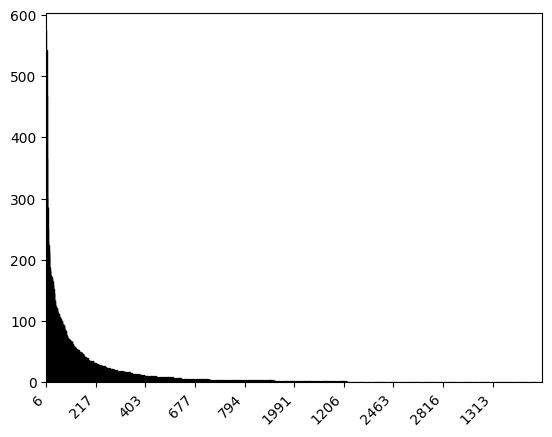

<Figure size 1000x600 with 0 Axes>

In [5]:
client_counts = df.groupby('client_id').size()

# Afficher la distribution du nombre de lignes par client_id
distribution = client_counts.value_counts()

# Affichage des résultats
print("Distribution du nombre de lignes par client_id :")
print(distribution)

# Visualiser la distribution avec un graphique
ax = distribution.plot(kind='bar', color='skyblue', edgecolor='black')
# Rotation des labels de l'axe des x pour les rendre lisibles
plt.xticks(rotation=45, ha='right')

# Ajuster la taille des labels si nécessaire
plt.xticks(fontsize=10)

# Réduire le nombre de ticks si nécessaire pour améliorer la lisibilité
plt.xticks(ticks=range(0, len(distribution), max(1, len(distribution)//10)))

# Ajuster la taille de la figure pour donner plus de place aux labels
plt.figure(figsize=(10, 6))

# S'assurer que tout est bien espacé
plt.tight_layout()

# Afficher le graphique
plt.show()


In [6]:
# Compter le nombre d'ID clients distincts
num_unique_clients = df['client_id'].nunique()

# Afficher le résultat
print(f"Nombre d'ID clients uniques dans la table : {num_unique_clients}")


Nombre d'ID clients uniques dans la table : 23662


In [7]:
# Filtrer les lignes où is_interaction == 1
clients_with_int = df[df['is_interaction'] == 1]

# Compter le nombre d'ID clients distincts ayant au moins un is_seen = 1
num_clients_with_int = clients_with_int['client_id'].nunique()

# Afficher le résultat
print(f"Nombre d'ID clients ayant au moins un is_interaction = 1 : {num_clients_with_int}")

Nombre d'ID clients ayant au moins un is_interaction = 1 : 11087


In [9]:
# Étape 1 : Compter le nombre total de triplets (client_id, date, searchkeyword) pour chaque client_id
total_triplets = df.groupby(['client_id', 'date', 'searchkeyword']).size().reset_index(name='total_triplet_count')

# Étape 2 : Compter le nombre de triplets avec au moins une interaction (is_interaction = 1) pour chaque client_id
interaction_triplets = df[df['is_interaction'] == 1].groupby(['client_id', 'date', 'searchkeyword']).size().reset_index(name='interaction_triplet_count')

# Étape 3 : Joindre les deux DataFrames sur les colonnes communes (client_id, date, searchkeyword)
result = pd.merge(total_triplets, interaction_triplets, on=['client_id', 'date', 'searchkeyword'], how='left')

# Remplir les valeurs manquantes d'interaction_triplet_count par 0 (si aucune interaction pour ce triplet)
result['interaction_triplet_count'] = result['interaction_triplet_count'].fillna(0)

# Étape 4 : Regrouper par client_id pour obtenir le nombre total de triplets et le nombre de triplets avec au moins une interaction
client_summary = result.groupby('client_id').agg(
    total_triplet_count=('total_triplet_count', 'sum'),
    interaction_triplet_count=('interaction_triplet_count', 'sum')
).reset_index()

# Étape 5 : Calculer le nombre de triplets sans interaction (total - interaction)
client_summary['no_interaction_triplet_count'] = client_summary['total_triplet_count'] - client_summary['interaction_triplet_count']

# Afficher le résultat
print(client_summary)

# Filtrer les clients sans interaction
clients_sans_int = client_summary[client_summary['interaction_triplet_count'] == 0]

# Compter le nombre d'ID clients distincts ayant au moins un is_seen = 1
num_clients_sans_int = clients_sans_int['client_id'].nunique()

# Afficher le résultat
print(f"Nombre d'ID clients sans interaction = 1 : {num_clients_sans_int}")


      client_id  total_triplet_count  interaction_triplet_count  \
0        000195                   59                        0.0   
1        0002b0                   70                        1.0   
2        000973                  130                        1.0   
3        0013cd                   84                        2.0   
4        0017ab                   18                        0.0   
...         ...                  ...                        ...   
23657    fff808                   78                        0.0   
23658    fff8e3                   15                        0.0   
23659    fffb11                   20                        0.0   
23660    fffc3d                  103                        0.0   
23661    ffff34                   90                        2.0   

       no_interaction_triplet_count  
0                              59.0  
1                              69.0  
2                             129.0  
3                              82.0  
4    

In [10]:
# Étape 6 : Calculer le taux d'interaction (interaction_rate)
client_summary['interaction_rate'] = client_summary['interaction_triplet_count'] / client_summary['total_triplet_count']

# Afficher le DataFrame avec interaction_rate
print(client_summary)

      client_id  total_triplet_count  interaction_triplet_count  \
0        000195                   59                        0.0   
1        0002b0                   70                        1.0   
2        000973                  130                        1.0   
3        0013cd                   84                        2.0   
4        0017ab                   18                        0.0   
...         ...                  ...                        ...   
23657    fff808                   78                        0.0   
23658    fff8e3                   15                        0.0   
23659    fffb11                   20                        0.0   
23660    fffc3d                  103                        0.0   
23661    ffff34                   90                        2.0   

       no_interaction_triplet_count  interaction_rate  
0                              59.0          0.000000  
1                              69.0          0.014286  
2                          

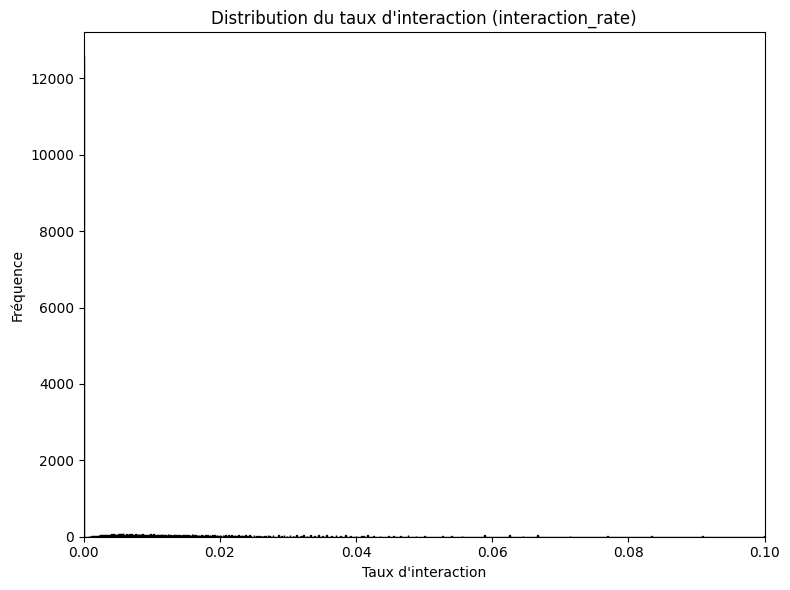

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(client_summary['interaction_rate'], bins=10000, edgecolor='black', color='skyblue')

# Ajouter des titres et des labels
plt.title('Distribution du taux d\'interaction (interaction_rate)')
plt.xlabel('Taux d\'interaction')
plt.ylabel('Fréquence')

# Zoom sur l'axe des abscisses (intervalle 0-0,4)
plt.xlim(0, 0.1)

# Afficher le graphique
plt.tight_layout()
plt.show()


In [12]:
# Filtrer les clients ayant un interaction_rate = 0
clients_with_no_interaction_rate = client_summary[client_summary['interaction_rate'] == 0]

# Compter le nombre d'ID clients distincts ayant interaction_rate = 0
num_clients_with_no_interaction_rate = clients_with_no_interaction_rate['client_id'].nunique()

# Afficher le résultat
print(f"Nombre d'ID clients ayant interaction_rate = 0 : {num_clients_with_no_interaction_rate}")


Nombre d'ID clients ayant interaction_rate = 0 : 12575


In [14]:
# Étape 1 : Compter le nombre de product_id distincts où is_seen == 1 pour chaque triplet
product_seen_counts = df[df['is_seen'] == 1].groupby(['client_id', 'date', 'searchkeyword'])['product_id'].nunique().reset_index(name='distinct_products_seen')

# Étape 2 : Calculer la moyenne du nombre de produits vus par client_id
average_products_seen_per_client = product_seen_counts.groupby('client_id')['distinct_products_seen'].mean().reset_index(name='avg_products_seen')

# Afficher le résultat
print(average_products_seen_per_client)


      client_id  avg_products_seen
0        000195          14.666667
1        0002b0           7.111111
2        000973           8.133333
3        0013cd           7.625000
4        0017ab           6.000000
...         ...                ...
23657    fff808           8.666667
23658    fff8e3           7.500000
23659    fffb11          10.000000
23660    fffc3d           8.000000
23661    ffff34           8.400000

[23662 rows x 2 columns]


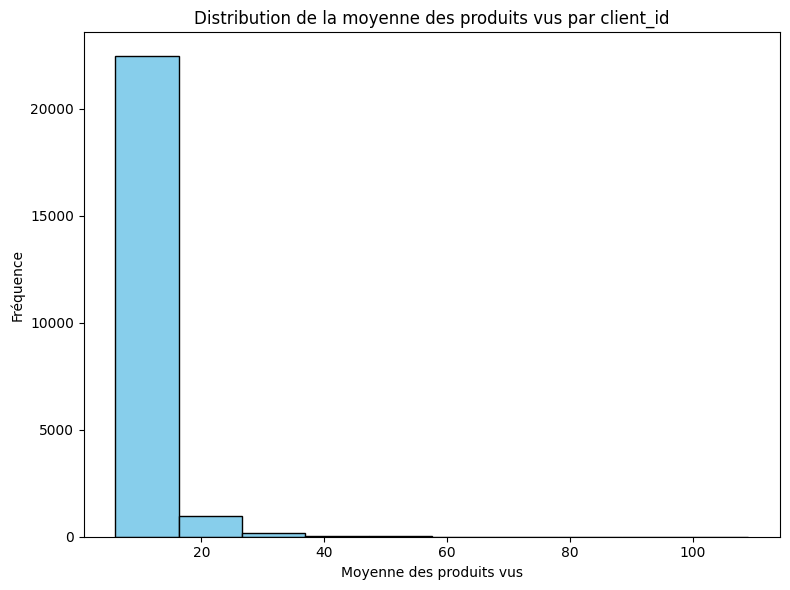

In [15]:
import matplotlib.pyplot as plt

# Afficher la distribution de la moyenne des produits vus par client_id
plt.figure(figsize=(8, 6))
plt.hist(average_products_seen_per_client['avg_products_seen'], bins=10, edgecolor='black', color='skyblue')

# Ajouter des titres et des labels
plt.title('Distribution de la moyenne des produits vus par client_id')
plt.xlabel('Moyenne des produits vus')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.tight_layout()
plt.show()


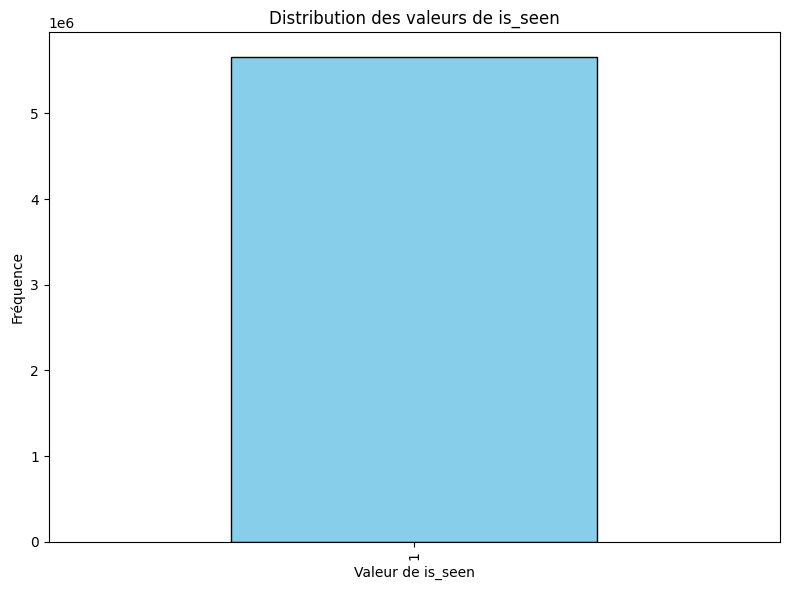

In [24]:
is_seen_counts = df['is_seen'].value_counts()

# Afficher la distribution avec un graphique à barres
plt.figure(figsize=(8, 6))
is_seen_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Ajouter des titres et des labels
plt.title('Distribution des valeurs de is_seen')
plt.xlabel('Valeur de is_seen')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.tight_layout()
plt.show()

In [16]:
gf = pd.read_parquet('google_analytics_events_data_anonymized (1).parquet')

In [17]:
gf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384842 entries, 0 to 7384841
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   date             int64 
 1   time             object
 2   user_id          object
 3   client_id        object
 4   device_category  object
 5   page_type        object
 6   product_ids      object
 7   event_name       object
dtypes: int64(1), object(7)
memory usage: 450.7+ MB


In [18]:
gf.head()

,date,time,user_id,client_id,device_category,page_type,product_ids,event_name
0,1,22:00:07.290246,/yDmzkKBxSke3n8BG9ykHw==,e6db74,desktop,Cart,"6aaaef4e, f8b83dad, 3ec03cb2, 71c801f2, 81c5948c",view_item_list
1,1,22:00:08.157687,p28CRQES90lRxwC/3if8Sw==,3933f1,desktop,Product Page,"11ba02c7, 516f5635, 45ac4a1a",view_item_list
2,1,22:00:08.157687,p28CRQES90lRxwC/3if8Sw==,3933f1,desktop,Product Page,"cfcc3671, 7372f999, d1c3a3fa",view_item_list
3,1,22:00:21.386387,/yDmzkKBxSke3n8BG9ykHw==,e6db74,desktop,Cart,"f8b83dad, 81c5948c, 71c801f2, 6aaaef4e, 3ec03cb2",view_item_list
4,1,22:00:24.521211,p28CRQES90lRxwC/3if8Sw==,3933f1,desktop,Product Page,"1b6b925c, 04a0ef24, 36adf49b, 38bd8027",view_item_list


In [19]:
# Obtenir la distribution des valeurs pour chaque colonne
device_category_counts = gf['device_category'].value_counts()
page_type_counts = gf['page_type'].value_counts()
event_name_counts = gf['event_name'].value_counts()

# Afficher les distributions
print("Distribution des valeurs dans 'device_category' :")
print(device_category_counts)
print("\nDistribution des valeurs dans 'page_type' :")
print(page_type_counts)
print("\nDistribution des valeurs dans 'event_name' :")
print(event_name_counts)

Distribution des valeurs dans 'device_category' :
device_category
desktop    7271341
mobile      108341
tablet        5160
Name: count, dtype: int64

Distribution des valeurs dans 'page_type' :
page_type
Product Page                   3547622
Search Results                 2630875
Cart                            531793
Product Category                420930
Order Process                    89803
Already Bought Product Page      57393
Order Confirmation               55154
Home                             22413
JobList Details Page             11734
Quote                            10647
Account                           2326
Order History                     1439
Saved Cart Details                1283
Brands                             474
Most Ordered Products              318
Comparison page                    203
Quick Order                        155
Backorders                         143
JobList Summary Page                57
Configurator                        50
Shop in shop Mai

In [20]:
# Identifier la catégorie d'utilisation des dispositifs pour chaque client
def device_category_type(devices):
    if len(devices) == 1:
        if 'desktop' in devices:
            return 'desktop_only'
        elif 'mobile' in devices or 'tablet' in devices:
            return 'mobile_or_tablet_only'
    return 'mixed'  # Si le client utilise plusieurs dispositifs

# Appliquer la fonction pour déterminer le type de dispositif pour chaque client
device_usage_category = gf.groupby('client_id')['device_category'].unique().apply(device_category_type).reset_index(name='device_usage_category')

# Ajouter cette feature à la table client_summary
client_summary = pd.merge(client_summary, device_usage_category, on='client_id', how='left')


In [21]:
print(client_summary)

      client_id  total_triplet_count  interaction_triplet_count  \
0        000195                   59                        0.0   
1        0002b0                   70                        1.0   
2        000973                  130                        1.0   
3        0013cd                   84                        2.0   
4        0017ab                   18                        0.0   
...         ...                  ...                        ...   
23657    fff808                   78                        0.0   
23658    fff8e3                   15                        0.0   
23659    fffb11                   20                        0.0   
23660    fffc3d                  103                        0.0   
23661    ffff34                   90                        2.0   

       no_interaction_triplet_count  interaction_rate device_usage_category  
0                              59.0          0.000000          desktop_only  
1                              69.0    

In [22]:
device = client_summary['device_usage_category'].value_counts()
print(device)

device_usage_category
desktop_only             19839
mixed                     3571
mobile_or_tablet_only      252
Name: count, dtype: int64


In [23]:
# Supprimer les colonnes existantes purchase_activity_score et purchase_activity_rate dans client_summary
client_summary.drop(columns=['purchase_activity_score', 'purchase_activity_rate'], inplace=True, errors='ignore')

# Calcul du score d'activité d'achat divisé par le total_triplet_count
purchase_activity_score = gf[gf['event_name'].isin(['purchase'])].groupby('client_id').size().reset_index(name='purchase_activity_score')

# Joindre le score d'activité d'achat avec le client_summary en ajoutant des suffixes pour éviter les conflits de noms
client_summary = pd.merge(client_summary, purchase_activity_score, on='client_id', how='left', suffixes=('_summary', '_score'))

# Diviser le score par le total_triplet_count pour obtenir le taux
client_summary['purchase_activity_rate'] = client_summary['purchase_activity_score'] / client_summary['total_triplet_count']

# Remplir les valeurs manquantes de purchase_activity_score par 0 si nécessaire
client_summary['purchase_activity_score'] = client_summary['purchase_activity_score'].fillna(0)
client_summary['purchase_activity_rate'] = client_summary['purchase_activity_rate'].fillna(0)



In [24]:
act = client_summary['purchase_activity_rate'].value_counts()
print(act)

purchase_activity_rate
0.000000    11212
0.142857      148
0.166667      145
0.125000      141
0.111111      110
            ...  
0.017742        1
0.026078        1
0.005231        1
0.555556        1
0.006403        1
Name: count, Length: 3236, dtype: int64


In [25]:
# Si 'date' représente un jour du mois (1-30), vous pouvez l'ajouter à une date de référence
# Exemple : Transformer 1 en 2023-01-01, 2 en 2023-01-02, etc.
gf['date'] = pd.to_datetime('2023-01-' + gf['date'].astype(str), format='%Y-%m-%d')

# Convertir les colonnes date et time en une seule colonne datetime
gf['datetime'] = pd.to_datetime(gf['date'].astype(str) + ' ' + gf['time'], errors='coerce')

# Vérifier si la conversion a réussi
print(gf[['date', 'time', 'datetime']].head())

        date             time                   datetime
0 2023-01-01  22:00:07.290246 2023-01-01 22:00:07.290246
1 2023-01-01  22:00:08.157687 2023-01-01 22:00:08.157687
2 2023-01-01  22:00:08.157687 2023-01-01 22:00:08.157687
3 2023-01-01  22:00:21.386387 2023-01-01 22:00:21.386387
4 2023-01-01  22:00:24.521211 2023-01-01 22:00:24.521211


In [26]:
# Calculer la différence de temps entre les recherches consécutives pour chaque client
gf['time_diff'] = gf.groupby('client_id')['datetime'].diff().dt.total_seconds()

# Calculer le temps moyen entre les recherches pour chaque client
client_summary['average_time_between_searches'] = gf.groupby('client_id')['time_diff'].mean().reset_index(name='average_time_between_searches')['average_time_between_searches']

# Remplir les valeurs manquantes par 0 (si nécessaire)
client_summary['average_time_between_searches'].fillna(0, inplace=True)
client_summary['average_time_between_searches_days'] = client_summary['average_time_between_searches'] / 86400

C:\Users\simon\AppData\Local\Temp\ipykernel_89656\3396166099.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  client_summary['average_time_between_searches'].fillna(0, inplace=True)


In [27]:
av = client_summary['average_time_between_searches_days'].value_counts()
print(av)

average_time_between_searches_days
0.000000    139
0.329478      1
0.073067      1
0.010445      1
0.030222      1
           ... 
0.366342      1
0.009430      1
0.633643      1
0.312975      1
0.148099      1
Name: count, Length: 23524, dtype: int64


In [28]:
pr = pd.read_parquet('products_data_anonymized.parquet')

In [29]:
pr.head()

,product_id,prd_long_description,prd_short_description,prd_title,brand_code,brand_name,prd_category_1,prd_category_2,prd_category_3,prd_category_4,has_image,prd_classification
0,a5f0e428,Cl-d<br/><br/>Cosses colorées à deux trous et ...,Cosse non isolée code couleur rouge 350 MCM 2 ...,Cosse non isolée code couleur rouge 350 MCM 2 ...,CMB,Cembre,PROCESS INDUSTRIEL,CONNECTIQUE ET RACCORDEMENT,RACCORD ET COSSE,"Raccord, Cosse",0.0,Cosse tubulaire pour conducteur en cuivre
1,6eb6d804,Application : > Permet le raccordement de 1 à ...,Collecteur raccord d'étage galvanisé - Diamètr...,Collecteur raccord d'étage galvanisé - Diamètr...,ALD,Aldes,"CHAUFFAGE ELEC, CLIM ET VENTILATION",VENTILATION,CONDUIT DE VENTILATION ET ACCESSOIRES,CONDUIT DE VENTILATION ET ACCESSOIRES,1.0,"Raccord T-Y, gaine de ventilation ronde"
2,7f11dead,La boîte Mini-Com® de fixation en saillie peut...,"Surface Mount Box, 4 Port, Off White","Surface Mount Box, 4 Port, Off White",PUI,Panduit Solutions Réseaux,INFRASTRUCTURE ET RESEAU,PRODUIT CUIVRE,CONNECTEUR ET PRISE AUTRE POUR RESEAU,Connecteur et Prise autre pour réseau,1.0,Boîtier en saillie pour de l'appareillage
3,a0e11db0,Rcc,RCC 500/450 - réduction conique concentrique d...,RCC 500/450 - réduction conique concentrique d...,ELG,Atlantic Climatisation & Ventilation,"CHAUFFAGE ELEC, CLIM ET VENTILATION",VENTILATION,CONDUIT DE VENTILATION ET ACCESSOIRES,CONDUIT DE VENTILATION ET ACCESSOIRES,1.0,"Cône d'aspiration, gaine de ventilation ronde"
4,55c32fba,"Luminaire profilé LED de grande qualité, en Hy...",pure3 green suspension noir sat. 4222x70mmLED ...,pure3 green suspension noir sat. 4222x70mm LED...,AH4,Planlicht,ECLAIRAGE,LUMINAIRE D'INTERIEUR DECORATIF,SUSPENSION D'ECLAIRAGE DECORATIF,SUSPENSION D'ECLAIRAGE DECORATIF LED INTEGREE,1.0,None


In [30]:
# Joindre la table df avec la table pr sur product_id pour obtenir prd_category_4
df_with_category = pd.merge(df, pr, on='product_id', how='left')

# Compter le nombre de prd_category_4 distinctes pour chaque client_id
client_category_count = df_with_category.groupby('client_id')['prd_category_4'].nunique().reset_index(name='unique_prd_category_count')

# Joindre cette feature à la table client_summary
client_summary = pd.merge(client_summary, client_category_count, on='client_id', how='left')


In [31]:
client_summary.head()

,client_id,total_triplet_count,interaction_triplet_count,no_interaction_triplet_count,interaction_rate,device_usage_category,purchase_activity_score,purchase_activity_rate,average_time_between_searches,average_time_between_searches_days,unique_prd_category_count
0,000195,59,0.0,59.0,0.000000,desktop_only,1.0,0.016949,28466.903233,0.329478,15
1,0002b0,70,1.0,69.0,0.014286,desktop_only,0.0,0.000000,22.120727,0.000256,13
2,000973,130,1.0,129.0,0.007692,desktop_only,0.0,0.000000,3497.635062,0.040482,42
3,0013cd,84,2.0,82.0,0.023810,desktop_only,0.0,0.000000,18817.541857,0.217796,21
4,0017ab,18,0.0,18.0,0.000000,desktop_only,0.0,0.000000,98955.091331,1.145314,1


In [32]:
cat = client_summary['unique_prd_category_count'].value_counts()
print(cat)

unique_prd_category_count
4      1031
2      1015
3       993
1       989
5       872
       ... 
364       1
372       1
223       1
571       1
298       1
Name: count, Length: 347, dtype: int64


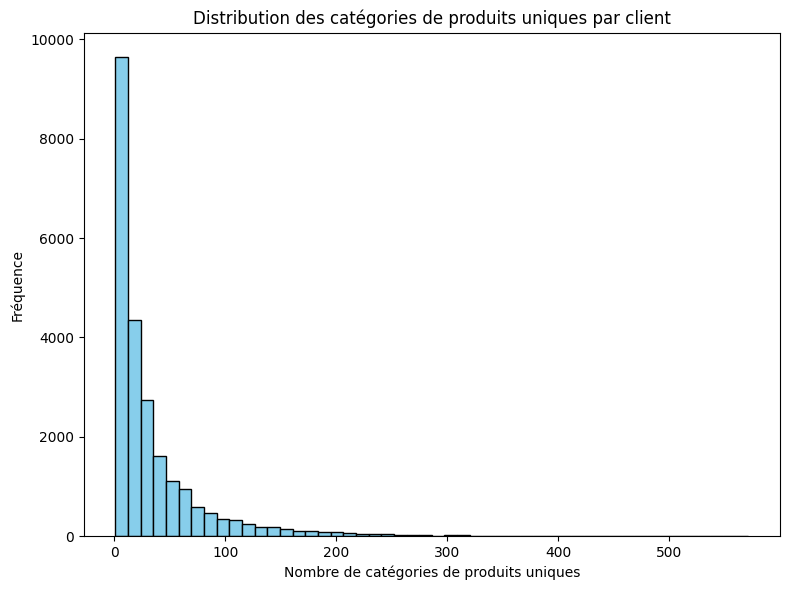

In [33]:
# Afficher la distribution de la colonne 'unique_prd_category_count' sous forme d'histogramme
plt.figure(figsize=(8, 6))
plt.hist(client_summary['unique_prd_category_count'], bins=50, edgecolor='black', color='skyblue')

# Ajouter des titres et des labels
plt.title('Distribution des catégories de produits uniques par client')
plt.xlabel('Nombre de catégories de produits uniques')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.tight_layout()
plt.show()

In [34]:
# Définir les intervalles
bins = [1, 10, 20, 30, 40, 50, 75, 100, 150, 200, 300, 400, 500, 600]

# Définir les labels pour chaque intervalle
labels = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-75', '76-100', '101-150', '151-200', '201-300', '301-400', '401-500', '501-600']

# Appliquer le binning sur la colonne 'unique_prd_category_count'
client_summary['prd_category_bin'] = pd.cut(client_summary['unique_prd_category_count'], bins=bins, labels=labels, right=True, include_lowest=True)

# Afficher les résultats
print(client_summary[['client_id', 'unique_prd_category_count', 'prd_category_bin']].head())


  client_id  unique_prd_category_count prd_category_bin
0    000195                         15            11-20
1    0002b0                         13            11-20
2    000973                         42            41-50
3    0013cd                         21            21-30
4    0017ab                          1             1-10


In [35]:
b = client_summary['prd_category_bin'].value_counts()
print(b)

prd_category_bin
1-10       8500
11-20      4571
21-30      2677
51-75      1956
31-40      1799
41-50      1239
101-150    1033
76-100      976
151-200     473
201-300     354
301-400      75
401-500       6
501-600       3
Name: count, dtype: int64


In [36]:
client_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23662 entries, 0 to 23661
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   client_id                           23662 non-null  object  
 1   total_triplet_count                 23662 non-null  int64   
 2   interaction_triplet_count           23662 non-null  float64 
 3   no_interaction_triplet_count        23662 non-null  float64 
 4   interaction_rate                    23662 non-null  float64 
 5   device_usage_category               23662 non-null  object  
 6   purchase_activity_score             23662 non-null  float64 
 7   purchase_activity_rate              23662 non-null  float64 
 8   average_time_between_searches       23662 non-null  float64 
 9   average_time_between_searches_days  23662 non-null  float64 
 10  unique_prd_category_count           23662 non-null  int64   
 11  prd_category_bin            

In [37]:
# Effectuer la jointure entre client_summary et average_products_seen_per_client sur client_id
client_summary = pd.merge(client_summary, average_products_seen_per_client[['client_id', 'avg_products_seen']], on='client_id', how='left')

# Vérifier le résultat
print(client_summary[['client_id', 'avg_products_seen']].head())


  client_id  avg_products_seen
0    000195          14.666667
1    0002b0           7.111111
2    000973           8.133333
3    0013cd           7.625000
4    0017ab           6.000000


In [38]:
# Sélectionner les colonnes spécifiées
columns_to_export = ['client_id', 'interaction_rate', 'device_usage_category', 'average_time_between_searches_days', 'prd_category_bin', 'purchase_activity_rate', 'avg_products_seen']

# Créer un DataFrame avec les colonnes sélectionnées
client_summary_selected = client_summary[columns_to_export]

# Enregistrer le DataFrame sous forme de fichier CSV
client_summary_selected.to_csv('client_summary_segmentation.csv', index=False)
